In [1]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import gdal

In [2]:
rootdir = r'D:\Projects\WAZE Data'
os.chdir(rootdir)
out_path = r'C:\Users\User\Desktop\Waze Congestion\August'

In [4]:
for d in os.listdir(rootdir):
    if '201708' in d:
        path = os.path.join(rootdir, d)
        # new tree to instore information
        waze_congest = ET.Element('root')
        ids = {}
        for file in os.listdir(path):
            tree = ET.parse(os.path.join(path,file), ET.XMLParser(encoding='utf-8'))
            root = tree.getroot()
            channel = root[0]
            for item in channel.findall('item'):
                if item.find('title')is not None and item.find('title').text=='alert':
                    id = item.find('{http://www.linqmap.com}uuid')
                    type = item.find('{http://www.linqmap.com}type')
                    if id is None:
                        continue
                    if type is None:
                        continue
                    #print id.text
                    if id.text not in ids.keys():
                        if type.text =='ACCIDENT' or type.text =='JAM':
                            ids[id.text]=1
                            waze_congest.append(item)
                    else:
                        ids[id.text]+=1
        #export xml file
        t = ET.ElementTree(waze_congest)
        t.write(os.path.join(out_path, d +'.xml'))
        print("reports for" + d + ": "+str(len(ids)))

reports for20170801: 3931
reports for20170802: 4032
reports for20170803: 4605
reports for20170804: 5734
reports for20170805: 1854
reports for20170806: 1610
reports for20170807: 3204
reports for20170808: 3302
reports for20170809: 3654
reports for20170810: 4597
reports for20170811: 4884
reports for20170812: 1620
reports for20170813: 937
reports for20170814: 4506
reports for20170815: 4724
reports for20170816: 5243
reports for20170817: 5847
reports for20170818: 5507
reports for20170819: 2492
reports for20170820: 3122
reports for20170821: 13388
reports for20170822: 8049
reports for20170823: 5105
reports for20170824: 5564
reports for20170825: 4567
reports for20170826: 1035
reports for20170827: 1001
reports for20170828: 3995
reports for20170829: 5761
reports for20170830: 5802
reports for20170831: 6430


In [10]:
# step 2 data for whole month
in_path = r'C:\Users\User\Desktop\Waze Congestion\August'
out_path = r'C:\Users\User\Desktop\Waze Congestion'
output_xml = ET.Element('root')
ids = []
for d in os.listdir(in_path):
    path = os.path.join(in_path, d)
    tree = ET.parse(path, ET.XMLParser(encoding='utf-8'))
    root = tree.getroot()
    for item in root.findall('item'):
        id = item.find('{http://www.linqmap.com}uuid').text
        if id not in ids:
            output_xml.append(item)
            ids.append(id)
t = ET.ElementTree(output_xml)
t.write(os.path.join(out_path,'August.xml'))
print("reports for August: "+str(len(ids)))

reports for August: 135692


In [21]:
# write the xml to csv file
class XML2DataFrame:

    def __init__(self, xml_data):
        self.root = ET.parse(xml_data).getroot()

    def parse_root(self, root):
        return [self.parse_element(child) for child in iter(root)]

    def parse_element(self, element, parsed=None):
        if parsed is None:
            parsed = dict()
        for key in element.keys():
            parsed[key] = element.attrib.get(key)
        if element.text:
            parsed[element.tag] = element.text
        for child in list(element):
            self.parse_element(child, parsed)
        return parsed

    def process_data(self):
        structure_data = self.parse_root(self.root)
        return pd.DataFrame(structure_data)

xml2df = XML2DataFrame(os.path.join(out_path,'August.xml'))
xml_dataframe = xml2df.process_data()
xml_dataframe.to_csv(os.path.join(out_path,'August.csv'))

In [27]:
import gdal
import networkx as nx
from geopy.distance import vincenty
import pandas as pd
from shapely.geometry import LineString, Point, LinearRing
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

In [29]:
# read the shapefile as Graph
G = nx.read_shp(r'shapefiles/knox_all_roads1.shp',simplify = False)
nodes = G.nodes()
edges = G.edges(data=True)

In [30]:
# check how many nodes and edges
print(len(nodes))
print(len(edges))

43158
47054


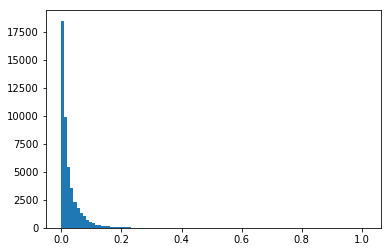

In [31]:
# check the segment length
import numpy as np
import matplotlib.pyplot as plt

distance = []
for key in edges:
    key[2]['weight']= vincenty(key[0], key[1]).miles
    distance.append(vincenty(key[0], key[1]).miles)
dist_array = np.array(distance)
plt.hist(dist_array, bins=100)
plt.show()

In [32]:
# read waze data
waze_df = pd.read_csv(r'shapefiles/waze_knox_allroads.csv',parse_dates=['pubDate'])
waze_df['pubDate'] = waze_df['pubDate'] - timedelta(hours=4)

In [39]:
# get the projection of waze jam report locaiton on the road network
pro_list = []
for df, row in waze_df.iterrows():
    projection = {}
    start_end_node = {}
    distance = {}
    point = Point(float(row['point'].split(' ')[1]), float(row['point'].split(" ")[0]))
    point_buffer = point.buffer(0.005) # create a buffer zone
    for key in edges:
        startNode = key[0]
        endNode = key[1]
        line = LineString([startNode,endNode])
        if point_buffer.intersects(line):
            d = line.project(point)
            p = line.interpolate(d)
            closest_point_coords = list(p.coords)[0]
            if vincenty(closest_point_coords, point.coords).miles < 0.01:
                distance[(key[0], key[1])] = vincenty(closest_point_coords, point.coords).miles
                projection[(key[0], key[1])] = closest_point_coords
                start_end_node[(key[0], key[1])] = (startNode, endNode)
    if len(distance)==0:
        pro_list.append((0,0))
        continue
    # get the minimum distance to get projection point
    MinKey = min(distance,key = distance.get)
    pro_list.append(projection[MinKey])
    G.add_node(projection[MinKey])
    G.add_edges_from([(start_end_node[MinKey][0],projection[MinKey]),(projection[MinKey], start_end_node[MinKey][1])])
pro_se = pd.Series(pro_list)
waze_df['projection'] = pro_se.values
waze_df.to_csv('projected_waze_allroads.csv')

In [40]:
# distance matrix
for (u,v,d) in G.edges(data=True):
    d['weight'] = vincenty(u, v).miles
    
dist = {}
for key in G.edges(data=True):
    dist[(key[0], key[1])] = key[2]['weight']
    dist[(key[1], key[0])] = key[2]['weight']

nx.write_gpickle(G, 'projection_allroads.gpickle')
    
H = G.to_undirected() # change Digraph to unDigraph

In [41]:
len(dist)

120230

In [42]:
len(G.edges())

60272

In [43]:
# dijkstra algorithm
def Dijkstra(H, s, distThre, df):
    d = {}
    Q = [s]
    neighbor_list = []
    d[s] = 0
    visited = [s]
    weight = 0
    while Q is not None:
        u = Q[0]
        Q.remove(u)
        for p in H.neighbors(u):
            weight = dist[(u,p)]
            if p not in visited and d[u]+ weight<float('inf') and p not in Q:
                d[p] = d[u] + weight
                Q = Q + [p]
        if not Q:
            return neighbor_list
        Q.sort(key=lambda x:d[x])
        #print(d[Q[0]])
        if d[Q[0]]> distThre:
            return neighbor_list
        else:
            neighbor_list.append(df.loc[df['projection']==Q[0],'OBJECTID']-1)
        if Q[0] not in visited:
            visited.append(Q[0])

In [44]:
## DBSCAN algorithms impelment this algorithm and find the incident boundary 
def RangeQuery(df,distThre,timeThre,index):
    Neighbors = []
    start = df.loc[index]
    startPoint =  (float(start['projection'][1:-1].split(',')[0]), float(start['projection'][1:-1].split(',')[1]))
    
    # filter by time 
    min_time = start['pubDate'] - timedelta(seconds=timeThre*60)
    max_time = start['pubDate'] + timedelta(seconds=timeThre*60)
    df = df.loc[(df['pubDate'] >= min_time) & (df['pubDate'] <= max_time)]
    '''
    #filter by dijkstra distance 
    N = []
    N = Dijkstra(H, startPoint, distThre, df)
    print(N)
    Neighbors = set(df.index).union(set(N))
    return Neighbors    
    
    for idx, row in df.iterrows():
        endPoint =  (float(df.loc[idx]['projection'][1:-1].split(',')[0]), float(df.loc[idx]['projection'][1:-1].split(',')[1]))
        try:
            length, path = nx.bidirectional_dijkstra(H,startPoint, endPoint)
        except nx.NetworkXNoPath:
            length = 100
        if length <= distThre:
            Neighbors.append(idx)
    return set(Neighbors)
    '''
    
    # filter by dijkstra distance 
    sub_graph = nx.ego_graph(H, startPoint, center=False, undirected=True,distance='weight')
    neig_points = sub_graph.nodes()
    neig_points = [str(p) for p in neig_points]
    df = df.loc[df['projection'].isin(neig_points)]
    Neighbors = set(df.index)
    return Neighbors
    
def DBSCAN(df, disThre,timeThre, minPts):
    cluster_id = -1 # cluster number 
    stack = []     # cluster classification  
    # for each point in database
    for idx, row in df.iterrows():
        print(idx)
        if df.loc[idx]['label'] == 'unmarked':
            Neighbors = RangeQuery(df, distThre, timeThre, idx)
            if len(Neighbors) < minPts:
                df.set_value(idx, 'label', 'Noise')
            else:
                cluster_id += 1
                print(cluster_id)
                df.set_value(idx, 'label', cluster_id)  # label core point
                
                # assign core's label to its neighborhood
                for neig_idx in Neighbors:
                    df.set_value(neig_idx, 'label', cluster_id)
                    stack.append(neig_idx)  # append neighborhood to stack
               
                # find new neighbors from core point neighborhood 
                while len(stack)>0:
                    print(stack)
                    current_point_index = stack.pop()
                    new_neighborhood = RangeQuery(df, distThre, timeThre, current_point_index)
                    
                    # current point is a new core
                    if len(new_neighborhood)>= minPts:
                        for idx in new_neighborhood:
                            neig_cluster = df.loc[idx]['label']
                            if neig_cluster == 'Noise':
                                df.set_value(idx, 'label',cluster_id)
                            if neig_cluster == 'unmarked':
                                df.set_value(idx, 'label',cluster_id)
                                stack.append(idx)                
    return df     

In [49]:
# load waze_data
df = pd.read_csv(r'projected_waze_allroads.csv', parse_dates = ['pubDate' ])
waze_df = df[['OBJECTID', 'pubDate', 'uuid', 'projection']]
waze_df['label'] = 'unmarked'
waze_df = waze_df.loc[waze_df['projection']!='(0, 0)']

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [51]:
waze_df

,OBJECTID,pubDate,uuid,projection,label
0,1,2017-07-31 23:57:31,8c92f094-d76f-3646-855e-0ef886a96cc6,"(-83.71290716975433, 35.996930670598275)",unmarked
1,2,2017-08-01 00:03:30,95a77b00-059e-3f5a-bef8-143fda6465b6,"(-83.70506392522118, 35.99689067409041)",unmarked
2,3,2017-08-01 00:04:14,292b1aa1-7fd0-3fad-8021-95faf6f0bc96,"(-83.7061589251311, 35.9968976881528)",unmarked
3,4,2017-08-01 00:27:00,c200aeb6-df84-303b-878b-328fbc341caf,"(-83.72224728844016, 35.99781395041492)",unmarked
4,5,2017-08-01 00:33:00,06dcbcd2-8aae-3085-a68a-b7379ea11fb5,"(-83.69634400266943, 35.996822672220894)",unmarked
5,6,2017-08-01 00:49:17,4789ed4c-6573-3172-8eef-eb2c056710d7,"(-83.69650700000264, 35.99682399967578)",unmarked
6,7,2017-08-01 06:03:19,7f234550-0baa-3b99-8747-acaebd5443e2,"(-83.69415571039103, 35.996789103316736)",unmarked
7,8,2017-08-01 07:40:08,a206ce0d-a30d-315f-92f1-c22657c4c3fc,"(-83.98043003998337, 36.01449217445899)",unmarked
8,9,2017-08-01 07:40:27,a42ac46d-37aa-3c8d-b42a-e277c3067f52,"(-84.10882455894155, 35.91401925491325)",unmarked
9,10,2017-08-01 07:39:56,ee17bd5f-2d99-33ff-b68b-17d4b0e17bf5,"(-84.10273140647735, 35.91537412424879)",unmarked


In [52]:
# setting up threshold 
distThre = 0.8  #distance in mile
timeThre = 10   #time in minutes
minPts = 4      #minimum points to define a cluster 
label = DBSCAN(waze_df, distThre,timeThre, minPts)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
0
[26, 27, 28, 29]
[26, 27, 28]
[26, 27]
[26]
26
27
28
29
30
31
32
1
[33, 34, 35, 36]
[33, 34, 35]
[33, 34]
[33]
33
34
35
36
37
38
39
40
2
[42, 43, 45, 49, 52, 55]
[42, 43, 45, 49, 52]
[42, 43, 45, 49]
[42, 43, 45, 46]
[42, 43, 45, 41]
[42, 43, 45, 47]
[42, 43, 45]
[42, 43]
[42]
41
42
43
44
45
46
47
48
49
50
3
[48, 51, 53, 54]
[48, 51, 53]
[48, 51]
[48]
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
4
[97, 100, 101, 102, 95]
[97, 100, 101, 102, 104]
[97, 100, 101, 102]
[97, 100, 101]
[97, 100, 99]
[97, 100]
[97]
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
5
[144, 157, 150, 151]
[144, 157, 150]
[144, 157]
[144]
139
140
141
143
144
146
147
148
149
150
151
152
153
6
[167, 148, 158, 159]
[167, 148, 158]
[167, 148]
[167

1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
39
[1048, 1049, 1050, 1047]
[1048, 1049, 1050]
[1048, 1049]
[1048]
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
40
[1082, 1087, 1086, 1079]
[1082, 1087, 1086]
[1082, 1087, 1085]
[1082, 1087]
[1082]
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
41
[1105, 1107, 1108, 1109]
[1105, 1107, 1108, 1106]
[1105, 1107, 1108]
[1105, 1107]
[1105]
1105
1106
1107
1108
1109
1110
1111
1112
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1145
1146
1147
1148
1149
1150
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178


2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2097
2098
2099
2101
2102
2103
2104
66
[2120, 2099, 2092, 2118]
[2120, 2099, 2092]
[2120, 2099]
[2120]
2105
2107
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
67
[2128, 2125, 2109, 2127]
[2128, 2125, 2109]
[2128, 2125]
[2128]
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
68
[2152, 2153, 2154, 2155]
[2152, 2153, 2154]
[2152, 2153]
[2152]
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
69
[2203, 2205, 2206, 2207]
[2203, 2205, 2206]
[2203, 2205]
[2203]
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
22

2889
2890
2891
2892
2893
2894
2895
2896
2897
2898
2899
2900
2901
2902
2903
2904
2905
90
[2914, 2923, 2925, 2932, 2901, 2909]
[2914, 2923, 2925, 2932, 2901, 2924]
[2914, 2923, 2925, 2932, 2901]
[2914, 2923, 2925, 2932]
[2914, 2923, 2925, 2950]
[2914, 2923, 2925]
[2914, 2923]
[2914]
2906
2907
2908
2909
2910
2911
2912
2913
2914
2915
2916
91
[2928, 2917, 2918, 2935]
[2928, 2917, 2918, 2929]
[2928, 2917, 2918]
[2928, 2917]
[2928]
2917
2918
2919
2920
2921
2922
92
[2936, 2907, 2926, 2919]
[2936, 2907, 2926]
[2936, 2907]
[2936]
[2949, 2953, 2942]
[2949, 2953]
[2949]
2923
2924
2925
2926
2927
2928
2929
2930
2931
2932
2933
93
[2938, 2906, 2930, 2927]
[2938, 2906, 2930]
[2938, 2906]
[2938]
[2939, 2941]
[2939]
2934
2935
2936
2937
2938
2939
2940
2941
2942
2943
2944
2945
2946
2947
2948
2949
2950
2951
2952
2953
2954
2955
2956
2957
2958
2959
2960
2961
2962
2963
2964
2965
2966
2967
2968
2969
2970
2971
2972
94
[2978, 2987, 2982, 2967]
[2978, 2987, 2982]
[2978, 2987]
[2978, 2992, 2993, 2994]
[2978, 2992, 

[3648, 3652, 3654, 3629]
[3648, 3652, 3654]
[3648, 3652, 3659]
[3648, 3652, 3653, 3655]
[3648, 3652, 3653]
[3648, 3652]
[3648]
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
121
[3658, 3661, 3662, 3665, 3666, 3672]
[3658, 3661, 3662, 3665, 3666]
[3658, 3661, 3662, 3665, 3663]
[3658, 3661, 3662, 3665]
[3658, 3661, 3662]
[3658, 3661]
[3658]
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
122
[3651, 3671, 3672, 3673, 3675]
[3651, 3671, 3672, 3673]
[3651, 3671, 3672]
[3651, 3671]
[3651]
3671
3672
3673
3674
3675
3676
3677
3678
3679
123
[3685, 3687, 3691, 3692, 3696]
[3685, 3687, 3691, 3692]
[3685, 3687, 3691]
[3685, 3687, 3680]
[3685, 3687]
[3685]
3680
3681
3682
3683
3684
124
[3704, 3689, 3706, 3701]
[3704, 3689, 3706]
[3704, 3689]
[3704]
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
125
[3708, 3711, 3694, 3695]
[3708, 3711, 3694]
[3708, 3711]
[3708]
[3720, 3

4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
143
[4069, 4070, 4072, 4073, 4052, 4053]
[4069, 4070, 4072, 4073, 4052]
[4069, 4070, 4072, 4073]
[4069, 4070, 4072, 4077, 4082, 4085]
[4069, 4070, 4072, 4077, 4082, 4102, 4094]
[4069, 4070, 4072, 4077, 4082, 4102]
[4069, 4070, 4072, 4077, 4082]
[4069, 4070, 4072, 4077]
[4069, 4070, 4072]
[4069, 4070]
[4069]
4051
4052
4053
4054
144
[4066, 4067, 4041, 4074, 4056]
[4066, 4067, 4041, 4074, 4075]
[4066, 4067, 4041, 4074, 4083, 4084, 4087, 4093]
[4066, 4067, 4041, 4074, 4083, 4084, 4087, 4099, 4107, 4092]
[4066, 4067, 4041, 4074, 4083, 4084, 4087, 4099, 4107, 4110]
[4066, 4067, 4041, 4074, 4083, 4084, 4087, 4099, 4107]
[4066, 4067, 4041, 4074, 4083, 4084, 4087, 4099]
[4066, 4067, 4041, 4074, 4083, 4084, 4087]
[4066, 4067, 4041, 4074, 4083, 4084]
[4066, 4067, 4041, 4074, 4083]
[4066, 4067, 4041, 4074]
[4066, 4067, 4041]
[4066, 4067]
[4066]
4055
4056
4057
4058
145
[4064, 4057, 4044, 4045]
[4064, 4057, 4044]
[4064, 4057]
[4064]
40

[4720, 4714, 4723]
[4720, 4714]
[4720]
4719
4720
4721
4722
4723
4724
4725
4726
4727
4728
4729
4730
4731
4732
4733
4734
4735
173
[4736, 4738, 4739, 4744]
[4736, 4738, 4739, 4746, 4742]
[4736, 4738, 4739, 4746]
[4736, 4738, 4739]
[4736, 4738]
[4736]
4736
4737
4738
4739
4740
4741
4742
4743
4744
4745
4746
4747
4748
4749
4750
4751
4752
4753
4754
4755
4756
4757
4758
4759
4760
4761
4762
4763
4764
4765
4766
4767
4768
4769
4770
4771
4772
4773
4774
4775
4776
4777
4778
4779
4780
4781
4783
4784
4785
4786
4787
4788
4789
4790
4791
4792
4793
4794
4795
4796
4797
4798
4799
4800
4801
4802
4803
4804
4805
4806
4807
4808
4809
4810
4811
4812
4813
4814
4815
4816
4817
4818
4819
4820
4821
4822
4823
4824
4825
4826
4827
174
[4834, 4839, 4825, 4826, 4829]
[4834, 4839, 4825, 4826]
[4834, 4839, 4825]
[4834, 4839]
[4834]
[4832, 4833, 4840, 4830, 4831]
[4832, 4833, 4840, 4830]
[4832, 4833, 4840]
[4832, 4833]
[4832]
4828
4829
4830
4831
4832
4833
4834
4835
4836
4837
4838
4839
4840
4841
4842
4843
4844
4845
4846
4847
484

5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466
5467
5468
5469
193
[5481, 5489, 5458, 5491, 5471]
[5481, 5489, 5458, 5491, 5486, 5485]
[5481, 5489, 5458, 5491, 5486, 5487]
[5481, 5489, 5458, 5491, 5486, 5479]
[5481, 5489, 5458, 5491, 5486]
[5481, 5489, 5458, 5491]
[5481, 5489, 5458]
[5481, 5489]
[5481]
5470
5471
5472
5473
5474
5475
5476
5477
5478
5479
5480
5481
5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498
5499
5500
5501
194
[5506, 5511, 5513, 5522, 5523]
[5506, 5511, 5513, 5522, 5524, 5532]
[5506, 5511, 5513, 5522, 5524]
[5506, 5511, 5513, 5522, 5538, 5527, 5533]
[5506, 5511, 5513, 5522, 5538, 5527, 5540, 5529, 5530]
[5506, 5511, 5513, 5522, 5538, 5527, 5540, 5529]
[5506, 5511, 5513, 5522, 5538, 5527, 5540, 5536, 5516, 5518]
[5506, 5511, 5513, 5522, 5538, 5527, 5540, 5536, 5516]
[5506, 5511, 5513, 5522, 5538, 5527, 5540, 5536]
[5506, 5511, 5513, 5522, 5538, 5527, 5540]
[5506, 5511, 5513, 5522, 5538, 5527,

[6456, 6457, 6458]
[6456, 6457]
[6456]
6452
6453
6454
6455
6456
6457
6458
6459
6460
6461
6462
6463
6464
6465
6466
6467
6468
6469
6470
6471
6472
218
[6464, 6473, 6468, 6469]
[6464, 6473, 6468]
[6464, 6473]
[6464]
6473
6474
6475
6476
6477
6478
6479
6480
6481
6482
6483
6484
6485
6486
6487
6488
219
[6496, 6498, 6499, 6505, 6515, 6490, 6491, 6494, 6495]
[6496, 6498, 6499, 6505, 6515, 6490, 6491, 6494]
[6496, 6498, 6499, 6505, 6515, 6490, 6491]
[6496, 6498, 6499, 6505, 6515, 6490]
[6496, 6498, 6499, 6505, 6515]
[6496, 6498, 6499, 6505]
[6496, 6498, 6499]
[6496, 6498]
[6496]
6489
6490
6491
6492
6493
6494
6495
6496
6497
6498
6499
6500
220
[6497, 6512, 6482, 6517, 6518, 6519]
[6497, 6512, 6482, 6517, 6518, 6529, 6532, 6534, 6507, 6524]
[6497, 6512, 6482, 6517, 6518, 6529, 6532, 6534, 6507]
[6497, 6512, 6482, 6517, 6518, 6529, 6532, 6534]
[6497, 6512, 6482, 6517, 6518, 6529, 6532]
[6497, 6512, 6482, 6517, 6518, 6529]
[6497, 6512, 6482, 6517, 6518]
[6497, 6512, 6482, 6517]
[6497, 6512, 6482]
[649

In [53]:
plt_df = label.loc[label['label']!='Noise']

In [54]:
# plot the distribution of waze jam reports
coords = plt_df['projection'].str.lstrip('(').str.rstrip(')').str.split(',')
plt_df['long'] = coords.str[0].astype(float)
plt_df['lat'] = coords.str[1].astype(float)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [55]:
plt_df

,OBJECTID,pubDate,uuid,projection,label,long,lat
25,26,2017-08-01 08:19:35,03a1f494-e942-3a3a-8129-c195ef383753,"(-83.91741790475099, 36.0317135750004)",0,-83.917418,36.031714
26,27,2017-08-01 08:19:42,b47b43b7-4d27-33f1-b89e-2c8ebc859392,"(-83.91812250976153, 36.03091756629335)",0,-83.918123,36.030918
27,28,2017-08-01 08:20:18,69aaab22-643b-3611-b0c4-a6fe9eadc916,"(-83.91859630115863, 36.03046505641648)",0,-83.918596,36.030465
28,29,2017-08-01 08:20:55,d6de5972-9290-3ccc-a6d3-020d207ea928,"(-83.91952691493164, 36.029689138216284)",0,-83.919527,36.029689
29,30,2017-08-01 08:21:30,9f5f63e2-534d-3168-8c08-915b0d801552,"(-83.92026603882927, 36.02921106661185)",0,-83.920266,36.029211
32,33,2017-08-01 08:33:48,12a56f57-a3e7-39ad-bfa7-bdbb745e8544,"(-84.04202860798242, 35.92894935206416)",1,-84.042029,35.928949
33,34,2017-08-01 08:37:10,b38fca8d-156f-3890-bd6c-61333352ea2e,"(-84.04058547944392, 35.92926776950319)",1,-84.040585,35.929268
34,35,2017-08-01 08:37:52,b9660167-5e59-3e2c-9bf1-15dddf0ebfe2,"(-84.03499758366775, 35.93050344711433)",1,-84.034998,35.930503
35,36,2017-08-01 08:41:56,a0afa392-c274-3518-81ee-8ff230431822,"(-84.0414267821098, 35.92908214124266)",1,-84.041427,35.929082
36,37,2017-08-01 08:42:17,d42202b1-3c19-3b2f-b2ca-f1d53bd79d67,"(-84.03654325960333, 35.93015458075761)",1,-84.036543,35.930155


In [56]:
import folium

folium_map = folium.Map(location=[35.963486, -83.949292], zoom_start=13,tiles='Stamen Toner')
'''
    [plt_df['label']==1]
    popup_text = """time: {}<br> label: {}"""
    popup_text = popup_text.format(row["pubDate"], row['label'])
'''

for index, row in plt_df.iterrows():
    folium.CircleMarker(location=(row["lat"],row["long"]), color='red',radius=2).add_to(folium_map)
    
folium_map

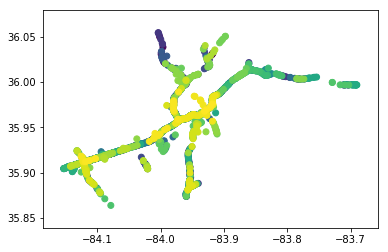

In [57]:
%matplotlib inline
plt.scatter(plt_df['long'],plt_df['lat'], c=plt_df['label'])

In [13]:
# run multiple times to get good results

minPts = 2      #minimum points to define a cluster 

# Run DBSCAN algorithm
disThre_list = [x/10 for x in range(1,16)]
timeThre_list = [x for x in range(5,30,5)]

for t in timeThre_list:
    for d in disThre_list:
        disThre = d
        timeThre = t
        N = {} # save dijkstra neighbors
        for idx, row in df.iterrows():
            s = (float(row['projection'][1:-1].split(',')[0]),float(row['projection'][1:-1].split(',')[1]))
            N[s] = Dijkstra(H, s, disThre)
        label = DBSCAN(df, disThre,timeThre, minPts)

Number of points of 0.1 5 is 128
Number of clusters of 0.1 5 is 38
Number of points of 0.2 5 is 346
Number of clusters of 0.2 5 is 97
Number of points of 0.3 5 is 593
Number of clusters of 0.3 5 is 165
Number of points of 0.4 5 is 857
Number of clusters of 0.4 5 is 231
Number of points of 0.5 5 is 1103
Number of clusters of 0.5 5 is 290
Number of points of 0.6 5 is 1314
Number of clusters of 0.6 5 is 338
Number of points of 0.7 5 is 1558
Number of clusters of 0.7 5 is 392
Number of points of 0.8 5 is 1802
Number of clusters of 0.8 5 is 440
Number of points of 0.9 5 is 2007
Number of clusters of 0.9 5 is 471
Number of points of 1.0 5 is 2178
Number of clusters of 1.0 5 is 501
Number of points of 1.1 5 is 2369
Number of clusters of 1.1 5 is 530
Number of points of 1.2 5 is 2472
Number of clusters of 1.2 5 is 539
Number of points of 1.3 5 is 2586
Number of clusters of 1.3 5 is 544
Number of points of 1.4 5 is 2693
Number of clusters of 1.4 5 is 557
Number of points of 1.5 5 is 2816
Number

In [38]:
# change datetime format

waze_df['Time'] = waze_df['pubDate'].map(lambda x: datetime.strptime(x,'%a %b %d %H:%M:%S %z %Y')-timedelta(hours=4))
waze_df['Time'] = waze_df['Time'].map(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
waze_df['Time'].head()

waze_df.to_csv('waze_knox_time.csv')


#waze_df['Time'] = waze_df['Time'].map(lambda x: x-timedelta(hours=4))